In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import copy
import sys

import numpy as np
import matplotlib.pyplot as plt
#import src.diffusion_map as dmap
#import src.helpers as helpers
%matplotlib inline
plt.rcParams['figure.dpi'] = 100 # default is 75
plt.style.use('default')

import math

sys.path.insert(0, "..")
import dMap_based.models, dMap_based.utils, dMap_based.utils_LJ7
from utils_NN import LJ7_2,chiAB,q_theta

Using cpu device


In [18]:
model_output = 'model_output/'
data_folder = 'data/'
# filename = data_folder + 'LJ7delta_net.txt'
filename = data_folder + 'LJ7bins_confs.txt'

txtfile = True

if txtfile:
    import re
    sigma = 0.02

    LJtraj = [] 
    with open(filename, "r") as f:
        for line in f:
            # cleaning the bad chars in line
            line = line.strip()
            line = line.strip(" \\n")
            line = re.sub(r"(-[0-9]+\.)", r" \1", line)
            values = [float(value) for value in line.split()]
            LJtraj.append(values)
    data = np.array(LJtraj)
    print('adjusted data shape: ',np.shape(LJtraj))
else:
    data = np.loadtxt(adj_file,delimiter=",")

adjusted data shape:  (16641, 14)


# diffusion net based

In [3]:
sys.modules['models'] = dMap_based.models

use_C = False
MEP_loss = True
knn = 256
epsilon = 4

AE_model = torch.load(model_output + f'{example}_CVlearner_2D_crdnum_{use_C}_mep_{MEP_loss}.pt',map_location=torch.device('cpu') )

DDnet = torch.load(output_folder + f"{example}_DDnet_knn{knn}_eps{epsilon}_BinsConf_CrdNum.pt",map_location=torch.device('cpu'))

manifold = torch.load(model_output + f"{example}_manifold_learner_knn{knn}_eps{epsilon}_CrdNum.pt",map_location=torch.device('cpu'))
ptsClound = np.loadtxt(data_folder + f"ptsCloud_knn{knn}_eps{epsilon}_CrdNum.csv",delimiter=",").astype(np.float32)

pts_off = torch.from_numpy(ptsClound)

target= np.loadtxt(data_folder + f"{example}_eigens_knn{knn}_eps{epsilon}_CrdNum.csv", delimiter=',').astype(np.float32)

feature_data = (torch.from_numpy(dMap_based.utils_LJ7.sort_r2(data))).to(torch.float32)


target= np.loadtxt(data_folder + 'LJ8_eigens_knn1_eps3.csv', delimiter=',').astype(np.float32)



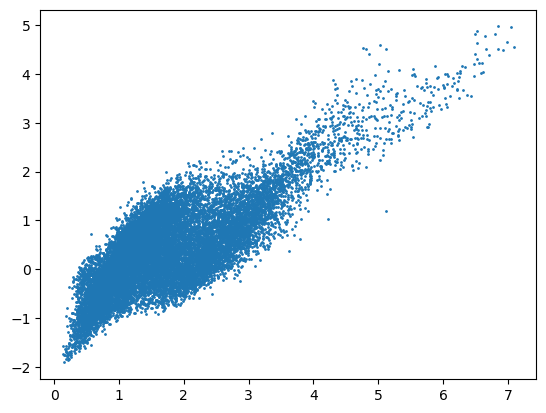

In [13]:
# CV space
CV_dmap,recon = AE_model(feature_data)
evecs = DDnet(feature_data)

plt.scatter(CV_dmap[:,0].detach(),CV_dmap[:,1].detach(), s = 1)
plt.show()

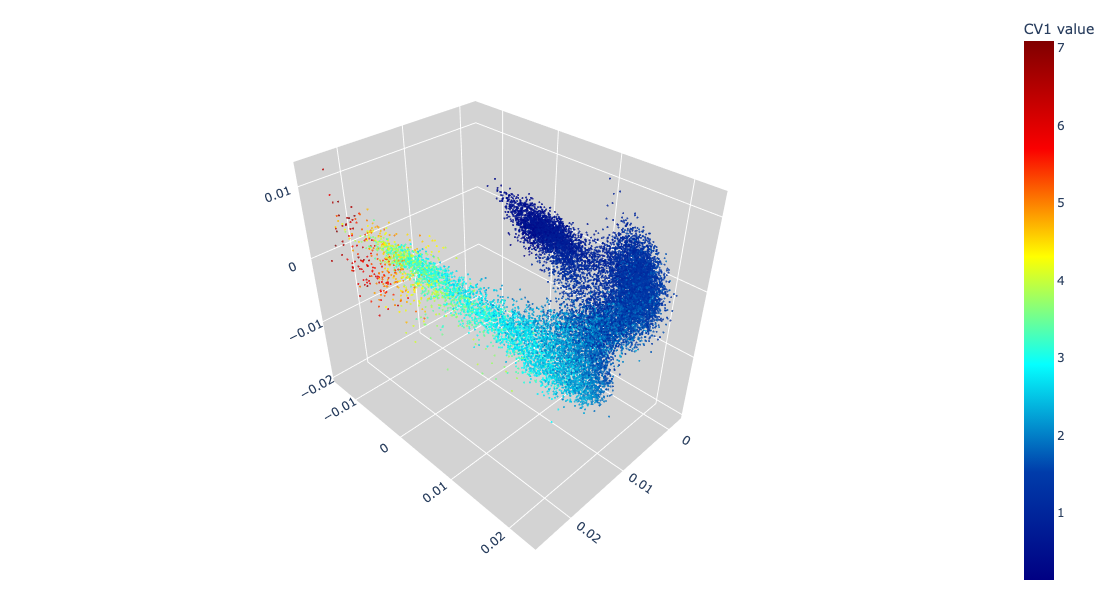

In [14]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Scatter3d(
        x=evecs[:, 0].detach(), 
        y=evecs[:, 1].detach(), 
        z=evecs[:, 2].detach(), 
        mode='markers',
        marker=dict(
            size=1.2,
            color=CV_dmap[:,0].detach(),  # Set color for points
            colorscale='Jet',  # Choose a colorscale (e.g., Viridis, Plasma, Jet, etc.)
            colorbar=dict(title='CV1 value'),  # Add a colorbar
            opacity=0.8
        )
    )
])

# fig.update_layout(title="Interactive Rotational 3D Plot")
camera = dict(
    eye=dict(x=1.5, y=1.5, z=1.5)  # Adjust x, y, z for the desired angle
)

# Update Layout
fig.update_layout(
    # title=dict(
    #     text="CV1 value in manifold via diffusion map",  # Title text
    #     font=dict(size=20),  # Title font size
    #     x=0.5,  # Center align the title
    #     y=0.9
    # ),
    scene_camera=camera,
    scene=dict(
        xaxis_title=r"",  # Custom X-axis label
        yaxis_title=r"",  # Custom Y-axis label
        zaxis_title=r"",  # Custom Z-axis label
        xaxis=dict(backgroundcolor='lightgrey', gridcolor='white'),  # Custom X-axis background
        yaxis=dict(backgroundcolor='lightgrey', gridcolor='white'),  # Custom Y-axis background
        zaxis=dict(backgroundcolor='lightgrey', gridcolor='white')   # Custom Z-axis background
    ),
    width=800,  # Set figure width
    height=600,  # Set figure height
    margin=dict(l=10, r=10, b=10, t=10),  # Set margins
    paper_bgcolor='white',  # Background color outside the plot
    plot_bgcolor='grey'  # Background color inside the plot
)

fig.write_image("data/manifold.pdf")
fig.show()

# plt.scatter(Mu2n3[indx,0],Mu2n3[indx,1],s = 1,c = CV_dmap[indx].detach())
# plt.colorbar()
# plt.show()
 
# plt.scatter(Mu2n3[indx,0],Mu2n3[indx,1],s = 1,c = wells)
# plt.colorbar()
# plt.show()



tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.9786, grad_fn=<MeanBackward0>)


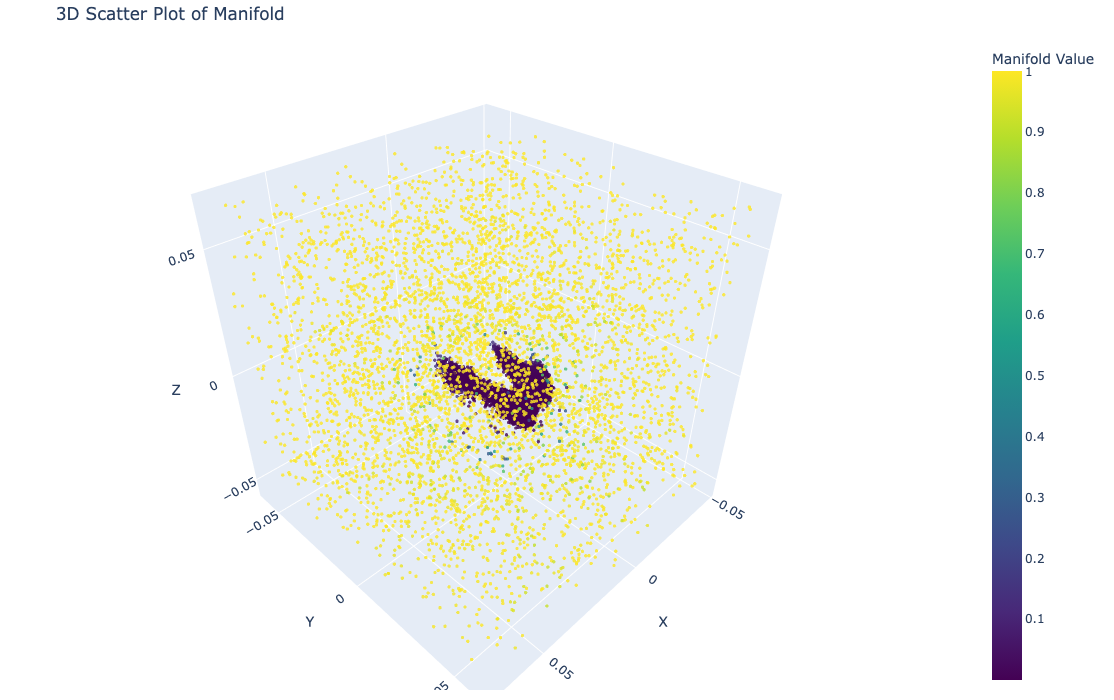

In [16]:
Manifold_on = manifold(evecs)
Manifold_off = manifold(pts_off)

print(Manifold_on.mean())
print(Manifold_off.mean())

All_pts = np.append(evecs.detach().numpy(), ptsClound, axis = 0)
manifold_value = np.append(Manifold_on.detach().numpy(),Manifold_off.detach().numpy(), axis = 0)

fig = go.Figure()

# Add scatter plot for the points with color mapping
fig.add_trace(go.Scatter3d(
    x=All_pts[:, 0], 
    y=All_pts[:, 1], 
    z=All_pts[:, 2], 
    mode='markers',
    marker=dict(
        size=2,  # Increase size slightly for visibility
        color=manifold_value[:,0],  # Use manifold_value for color mapping
        colorscale='Viridis',  # Change this to your preferred color scale (e.g., 'Jet', 'Plasma', etc.)
        colorbar=dict(title='Manifold Value'),  # Add a colorbar
        opacity=0.8
    )
))

# Update layout
fig.update_layout(
    title="3D Scatter Plot of Manifold",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
    ),
    width=800,
    height=700,
    margin=dict(l=10, r=10, b=10, t=40),
    # paper_bgcolor="white",
    # plot_bgcolor="lightgrey"
)

# Show the interactive plot
fig.show()